<a href="https://colab.research.google.com/github/pcarbomestre/SAR-VesselDetection-FisheriesMonitoring/blob/main/improved_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries

The virtual machines used in Colab for the runtimes are ephemeral, so some libraries not preinstalled in Colab environment have to be installed each time we open the notebook. More information about Colab [here](https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/0_colab.ipynb#scrollTo=fPP3Zw5iV2DP).

Detectron2 is a library that provides state-of-the-art detection and segmentation algorithms. It is not installed by default in the Colab environmebt so we have to install it each time we open a session.

More information about it at https://github.com/facebookresearch/detectron2.

In [ ]:
# install detectron2:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# After installation, you need to "restart runtime" in Colab.
exit(0) # This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1eqgndve
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1eqgndve
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2254a10de3a06536fb1d18b55417cd5ece192f59
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filen

Detectron2 is built on top of PyTorch. Therefore, it requires PyTorch to be imported in order to run it. Beside, we will load all detecron2 utilities and other commmon libraries we are going to use.

In [ ]:
import yaml
import torch, torchvision

# Detectron2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data.detection_utils import transform_instance_annotations

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from google.colab.patches import cv2_imshow
import copy
import PIL
from cv2 import hconcat

We also need to connect to our Google Drive accoung where we have stored our datasets, and where we are going to save our outputs.

In [ ]:
# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Registration of the custom dataset to detectron2

Retrieve previously created datasets compatible with detectron 2

In [ ]:
datasets_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/data/datasets/'

# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = datasets_path + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

The code snippet registers a dataset with Detectron2 by creating a data catalog and setting metadata for the dataset.

In [ ]:
pre = 'ssdd_aug_'

# Register
DatasetCatalog.clear()
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

Store metadata for each dataset.

In [ ]:
# metadata instances
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')

## Model loading

Load the model from the .pth file. Evaluate performance following Zhang et al. 2020 criteria.


In [ ]:
%cd /content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output
output = '//content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output/'
model_name = "./ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter"

/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output


Configure the instance for Detectron2. The inference should use the same or similar configuration with the parameters used in training.


In [ ]:
# detectron2 configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))  # path to the YAML configuration file for a specific pre-trained model
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has class ship
cfg.OUTPUT_DIR = model_name

Now we initializes the DefaultTrainer object form the configuration object cfg. Then we load the model form the previous checkpoint, in our case the final trained model.

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)  # model loads from the last_checkpoint file

[06/08 18:04:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[06/08 18:04:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter/model_final.pth ...
[06/08 18:05:01 d2.engine.hooks]: Loading scheduler from state_dict ...


## Evaluate model

In Zhang et al. (2020) paper, they perform the model evaluation by setting a score threshold to 0.5 and an intersection over union (IOU) threshold of detections as 0.5. This means that if the overlap area of a predictive box and a ground truth box exceeds or equals 50%, then ships in this box are detected successfully.

We can set those values form the following hyperparameters in te cfg model configuration.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Load custom weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # following Zhang et al. 2020
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5  # following Zhang et al. 2020

predictor = DefaultPredictor(cfg)

[06/08 18:05:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter/model_final.pth ...


**SCORE_THRESH_TEST** is a hyperparameter that determines the confidence threshold for object detection during inference. Any region proposal with a detection score lower than this threshold will be discarded. In this case, a threshold of 0.5 is set, which means that the model will only consider region proposals with a detection score greater than or equal to 0.5 during inference.

**NMS_THRESH_TEST** is another hyperparameter that determines the threshold for NMS during inference. NMS is a technique used to remove overlapping bounding boxes that refer to the same object. In this case, a threshold of 0.5 is set, which means that if two bounding boxes have an intersection over union (IoU) score greater than 0.5, the box with the lower score will be discarded.

## COCO Evaluator

We will evaluate its performance using AP metrics implemented in the COCO API.

In this ocassion, since the trainer configuration incorporated a mapper, we will define a new mapper for the inference. However, this does not have to include the augmentations.

Althugh, a mapper is not needed for inference, since the original input images have a different size and format than the images used during training (which where transformed), a mapper has to be used to resize or otherwise transform the input data so that it can be processed by the model.

So, while a mapper is not strictly necessary for inference, it is a necessary tool for ensuring that the input data is in the correct format for the model to produce accurate predictions. Actually, if we conduct a performance analyusis without the mapper, we will get low performance value.

The function below is a mapper without augmentations. This is similar to the one implemented for training the model but its only purpose is to match the model object so it can be used for inference.

In [ ]:
def mapper_wo(dataset_dict):

    # Make a copy of the input dict.
    dataset_dict = copy.deepcopy(dataset_dict)

    # Load image.
    image = utils.read_image(dataset_dict["file_name"], format="BGR") # Reads the image based on its filename. HWC image | 0-255 | uint8

    # Transform image.
    auginput = T.AugInput(image) # Define the augmentation input ("image" required, others optional).
    transform = T.Resize((1400, 1400),interp=PIL.Image.BILINEAR)(auginput) # Apply the transformation.
    image = torch.from_numpy(copy.deepcopy(auginput.image.transpose(2, 0, 1)))  #Change channel order from w*h*c to c*w*h

    # Transform annotations.
    annos = [
        transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
        if annotation.get("iscrowd", 0) == 0
    ]

    # Convert annotations to Instances and filter out the empty ones.
    instances = utils.annotations_to_instances(annos, image.shape[1:])

    # Add image and instances to the dictionary.
    dataset_dict["image"] = image #image[0,:,:]because utils.read_image() uses pillow converts the image from grayscale to bgr with 3 identical channels.
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_aug_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test', mapper_wo)

print(inference_on_dataset(trainer.model, val_loader, evaluator))

[06/08 18:05:20 d2.evaluation.coco_evaluation]: Trying to convert 'ssdd_aug_test' to COCO format ...
WARNING [06/08 18:05:20 d2.data.datasets.coco]: Using previously cached COCO format annotations at './ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter/ssdd_aug_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/08 18:05:35 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2378         |
|            |              |
[06/08 18:05:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/08 18:05:35 d2.data.common]: Serializing 736 elements to byte tensors and concatenating them all ...
[06/08 18:05:35 d2.data.common]: Serialized dataset takes 0.25 MiB
[06/08 18:05:35 d2.evaluation.evaluator]: Start inference on 736 batches


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/08 18:05:42 d2.evaluation.evaluator]: Inference done 11/736. Dataloading: 0.0026 s/iter. Inference: 0.2527 s/iter. Eval: 0.0003 s/iter. Total: 0.2556 s/iter. ETA=0:03:05
[06/08 18:05:47 d2.evaluation.evaluator]: Inference done 31/736. Dataloading: 0.0040 s/iter. Inference: 0.2537 s/iter. Eval: 0.0003 s/iter. Total: 0.2581 s/iter. ETA=0:03:01
[06/08 18:05:52 d2.evaluation.evaluator]: Inference done 50/736. Dataloading: 0.0050 s/iter. Inference: 0.2577 s/iter. Eval: 0.0003 s/iter. Total: 0.2631 s/iter. ETA=0:03:00
[06/08 18:05:57 d2.evaluation.evaluator]: Inference done 69/736. Dataloading: 0.0047 s/iter. Inference: 0.2585 s/iter. Eval: 0.0004 s/iter. Total: 0.2637 s/iter. ETA=0:02:55
[06/08 18:06:02 d2.evaluation.evaluator]: Inference done 89/736. Dataloading: 0.0045 s/iter. Inference: 0.2585 s/iter. Eval: 0.0004 s/iter. Total: 0.2635 s/iter. ETA=0:02:50
[06/08 18:06:07 d2.evaluation.evaluator]: Inference done 108/736. Dataloading: 0.0051 s/iter. Inference: 0.2601 s/iter. Eval: 0.00

In [ ]:
# test_offshore
evaluator = COCOEvaluator('ssdd_aug_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test_offshore',mapper_wo)

print(inference_on_dataset(trainer.model, val_loader, evaluator))


[06/08 18:38:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/08 18:38:08 d2.data.common]: Serializing 618 elements to byte tensors and concatenating them all ...
[06/08 18:38:08 d2.data.common]: Serialized dataset takes 0.20 MiB
[06/08 18:38:08 d2.evaluation.evaluator]: Start inference on 618 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[06/08 18:38:12 d2.evaluation.evaluator]: Inference done 11/618. Dataloading: 0.0034 s/iter. Inference: 0.2746 s/iter. Eval: 0.0003 s/iter. Total: 0.2783 s/iter. ETA=0:02:48
[06/08 18:38:17 d2.evaluation.evaluator]: Inference done 29/618. Dataloading: 0.0043 s/iter. Inference: 0.2774 s/iter. Eval: 0.0003 s/iter. Total: 0.2822 s/iter. ETA=0:02:46
[06/08 18:38:22 d2.evaluation.evaluator]: Inference done 47/618. Dataloading: 0.0057 s/iter. Inference: 0.2784 s/iter. Eval: 0.0003 s/iter. Total: 0.2845 s/iter. ETA=0:02:42
[06/08 18:38:27 d2.evaluation.evaluator]: Inference done 65/618. Dataloading: 0.0054 s/iter. Inference: 0.2790 s/iter. Eval: 0.0003 s/iter. Total: 0.2849 s/iter. ETA=0:02:37
[06/08 18:38:33 d2.evaluation.evaluator]: Inference done 82/618. Dataloading: 0.0067 s/iter. Inference: 0.2824 s/iter. Eval: 0.0003 s/iter. Total: 0.2898 s/iter. ETA=0:02:35
[06/08 18:38:38 d2.evaluation.evaluator]: Inference done 98/618. Dataloading: 0.0079 s/iter. Inference: 0.2860 s/iter. Eval: 0.000

In [ ]:
# test_inshore
evaluator = COCOEvaluator('ssdd_aug_test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test_inshore',mapper_wo)

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/08 18:12:19 d2.evaluation.coco_evaluation]: Trying to convert 'ssdd_aug_test_inshore' to COCO format ...
WARNING [06/08 18:12:19 d2.data.datasets.coco]: Using previously cached COCO format annotations at './ModelOutput/aug_faster_rcnn_R_101_FPN_3x_26000iter/ssdd_aug_test_inshore_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/08 18:12:24 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 883          |
|            |              |
[06/08 18:12:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/08 18:12:24 d2.data.common]: Serializing 117 elements to byte tensors and concatenating them all ...
[06/08 18:12:24 d2.data.common]: Serialized dataset takes 0.05 MiB
[06/08 18:12:24 d2.evaluation.evaluator]: Start inference on 117 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[06/08 18:12:28 d2.evaluation.evaluator]: Inference done 11/117. Dataloading: 0.0227 s/iter. Inference: 0.2907 s/iter. Eval: 0.0003 s/iter. Total: 0.3137 s/iter. ETA=0:00:33
[06/08 18:12:33 d2.evaluation.evaluator]: Inference done 29/117. Dataloading: 0.0096 s/iter. Inference: 0.2873 s/iter. Eval: 0.0003 s/iter. Total: 0.2975 s/iter. ETA=0:00:26
[06/08 18:12:38 d2.evaluation.evaluator]: Inference done 47/117. Dataloading: 0.0072 s/iter. Inference: 0.2838 s/iter. Eval: 0.0003 s/iter. Total: 0.2915 s/iter. ETA=0:00:20
[06/08 18:12:44 d2.evaluation.evaluator]: Inference done 65/117. Dataloading: 0.0067 s/iter. Inference: 0.2839 s/iter. Eval: 0.0003 s/iter. Total: 0.2910 s/iter. ETA=0:00:15
[06/08 18:12:49 d2.evaluation.evaluator]: Inference done 83/117. Dataloading: 0.0061 s/iter. Inference: 0.2839 s/iter. Eval: 0.0003 s/iter. Total: 0.2905 s/iter. ETA=0:00:09
[06/08 18:12:54 d2.evaluation.evaluator]: Inference done 101/117. Dataloading: 0.0055 s/iter. Inference: 0.2836 s/iter. Eval: 0.00

### Visualization

We can generate some images to compare the detected vessels using the model and the actual annotations.

In [ ]:
def printImage(ann, metadata, predictor=None, predFlag=False):
  # Read the image from the "file_name" field of the input annotation dictionary using OpenCV.
  im = cv2.imread(ann["file_name"])

  # Create a Visualizer object with the loaded image, metadata, and a scale factor of 0.5.
  v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.5)

  # If the "predFlag" parameter is True, then run the input image through the provided "predictor" model to get predictions.
  if predFlag:
    outputs = predictor(im)  # in detectron2 output format (https://detectron2.readthedocs.io/tutorials/models.html#model-output-format)
    # Draw the predicted instances on the image using the Visualizer object.
    # This line is moving the instances object to the CPU so that it can be used with the draw_instance_predictions() method of the Visualizer class which requires the input to be on the CPU.
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # If "predFlag" is False, then just draw the annotations from the input dictionary using the Visualizer object.
  else:
    out = v.draw_dataset_dict(ann)

  # Get the image data from the Visualizer object and flip the color channels from BGR to RGB.
  image = out.get_image()[:, :, ::-1]

  # Return the final image.
  return image

In [ ]:
os.makedirs(model_name + "/predImages", exist_ok=True)  # Create directory to save the images

Create three random images to be displayed.

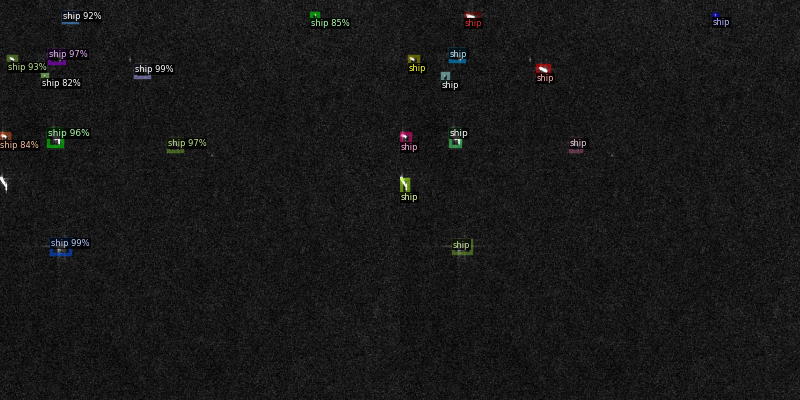

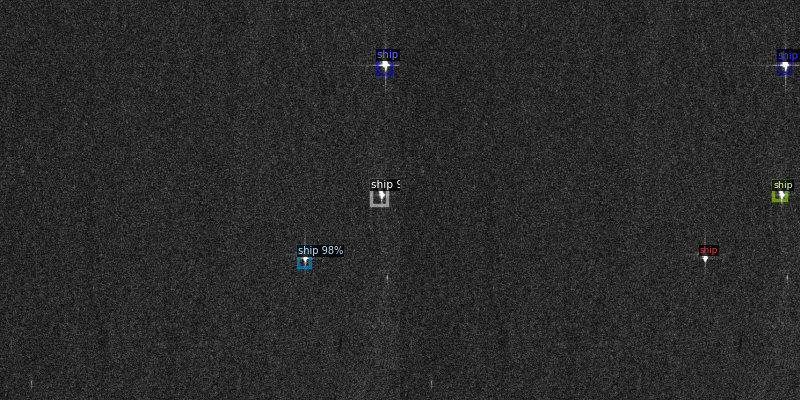

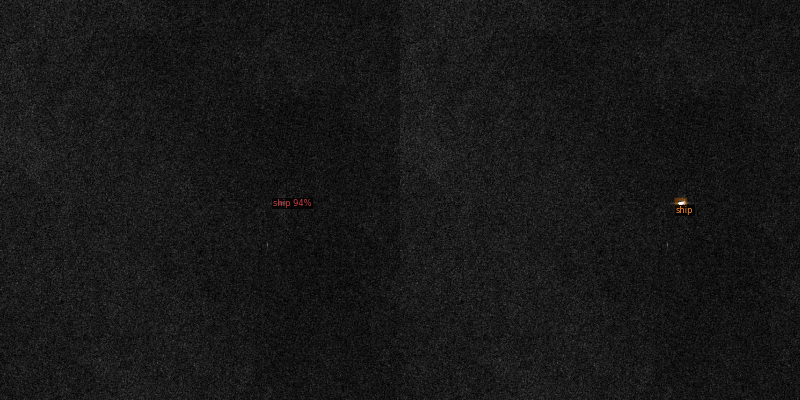

In [ ]:
dataset_dicts = get_dict("test")

# random.seed(9090)
num_samples = 3
for d in random.sample(dataset_dicts, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3)  # display an image
  cv2.imwrite(model_name + '/predImages/' + str(d["image_id"] + '.jpg'), image3)  # save an image

## Custom Evaluator

In [ ]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from collections import OrderedDict
from pycocotools.coco import COCO
import itertools
import contextlib
import torch
import copy
import os
import io

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [ ]:
class CustomEvaluator(DatasetEvaluator):
  def __init__(self, dataset_name, output_dir):
    self._cpu_device = torch.device("cpu")
    self.dataset_name = dataset_name
    self._metadata = MetadataCatalog.get(dataset_name)
    self._output_dir = output_dir

    if not hasattr(self._metadata, "json_file"):
      cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
      self._metadata.json_file = cache_path
      convert_to_coco_json(dataset_name, cache_path)

    json_file = PathManager.get_local_path(self._metadata.json_file)
    with contextlib.redirect_stdout(io.StringIO()):
        self._coco_api = COCO(json_file)

  def reset(self):
    self._predictions = []

  def process(self, inputs, outputs):
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device)
      if len(prediction) > 1:
          self._predictions.append(prediction)

    if self._output_dir:
      PathManager.mkdirs(self._output_dir)
      file_path = os.path.join(self._output_dir, self.dataset_name + "_predictions.pth")
      with PathManager.open(file_path, "wb") as f:
        torch.save(self._predictions, f)

  def evaluate(self):
    iou_threshold = 0.5
    num_instances = 0
    correct = []

    if len(self._predictions) == 0:
      return {}, {}, {}

    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)
      inds = predictions.get_fields()['scores'].sort(descending=True)[1]
      in_boxes = predictions.get_fields()['pred_boxes']
      in_boxes = in_boxes[inds]

      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno = self._coco_api.loadAnns(ann_ids)
      gt_boxes = [BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
                  for obj in anno if obj["iscrowd"] == 0]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

      overlaps = pairwise_iou(in_boxes, gt_boxes)
      _scores = torch.zeros(len(in_boxes))

      for j in range(min(len(predictions), len(gt_boxes))):
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          box_ind = argmax_overlaps[gt_ind]

          _scores[box_ind] = overlaps[box_ind, gt_ind]
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1

      _correct = (_scores >= iou_threshold).tolist()
      correct.extend(_correct)

    GT = len(self._coco_api.getAnnIds())
    TP = np.sum(np.array(correct))
    FP = len(correct) - TP
    FN = GT - TP

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    self._results = {
        "recall": recall,
        "precision": precision,
        "true positives": TP,
        "false positives": FP
    }

    return self._results



In [ ]:
# test
custEval = CustomEvaluator('ssdd_aug_test', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test',mapper_wo)

inference_test = inference_on_dataset(trainer.model, val_loader, custEval)
inference_test

[06/08 18:25:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/08 18:25:38 d2.data.common]: Serializing 736 elements to byte tensors and concatenating them all ...
[06/08 18:25:38 d2.data.common]: Serialized dataset takes 0.25 MiB
[06/08 18:25:38 d2.evaluation.evaluator]: Start inference on 736 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[06/08 18:25:42 d2.evaluation.evaluator]: Inference done 11/736. Dataloading: 0.0036 s/iter. Inference: 0.2713 s/iter. Eval: 0.0086 s/iter. Total: 0.2835 s/iter. ETA=0:03:25
[06/08 18:25:47 d2.evaluation.evaluator]: Inference done 29/736. Dataloading: 0.0047 s/iter. Inference: 0.2734 s/iter. Eval: 0.0092 s/iter. Total: 0.2877 s/iter. ETA=0:03:23
[06/08 18:25:52 d2.evaluation.evaluator]: Inference done 45/736. Dataloading: 0.0055 s/iter. Inference: 0.2825 s/iter. Eval: 0.0181 s/iter. Total: 0.3064 s/iter. ETA=0:03:31
[06/08 18:25:58 d2.evaluation.evaluator]: Inference done 61/736. Dataloading: 0.0061 s/iter. Inference: 0.2836 s/iter. Eval: 0.0188 s/iter. Total: 0.3091 s/iter. ETA=0:03:28
[06/08 18:26:03 d2.evaluation.evaluator]: Inference done 78/736. Dataloading: 0.0062 s/iter. Inference: 0.2833 s/iter. Eval: 0.0185 s/iter. Total: 0.3084 s/iter. ETA=0:03:22
[06/08 18:26:08 d2.evaluation.evaluator]: Inference done 95/736. Dataloading: 0.0062 s/iter. Inference: 0.2835 s/iter. Eval: 0.019

{'recall': 0.8498738435660219,
 'precision': 0.46685146685146683,
 'true positives': 2021,
 'false positives': 2308}

In [ ]:
# test_offshore
custEval = CustomEvaluator('ssdd_aug_test_offshore', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test_offshore',mapper_wo)

inference_test_offshore = inference_on_dataset(trainer.model, val_loader, custEval)
inference_test_offshore

[06/08 18:30:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/08 18:30:20 d2.data.common]: Serializing 618 elements to byte tensors and concatenating them all ...
[06/08 18:30:20 d2.data.common]: Serialized dataset takes 0.20 MiB
[06/08 18:30:20 d2.evaluation.evaluator]: Start inference on 618 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[06/08 18:30:24 d2.evaluation.evaluator]: Inference done 11/618. Dataloading: 0.0030 s/iter. Inference: 0.2723 s/iter. Eval: 0.0070 s/iter. Total: 0.2823 s/iter. ETA=0:02:51
[06/08 18:30:29 d2.evaluation.evaluator]: Inference done 29/618. Dataloading: 0.0070 s/iter. Inference: 0.2747 s/iter. Eval: 0.0085 s/iter. Total: 0.2905 s/iter. ETA=0:02:51
[06/08 18:30:34 d2.evaluation.evaluator]: Inference done 46/618. Dataloading: 0.0070 s/iter. Inference: 0.2754 s/iter. Eval: 0.0100 s/iter. Total: 0.2928 s/iter. ETA=0:02:47
[06/08 18:30:40 d2.evaluation.evaluator]: Inference done 62/618. Dataloading: 0.0076 s/iter. Inference: 0.2792 s/iter. Eval: 0.0144 s/iter. Total: 0.3016 s/iter. ETA=0:02:47
[06/08 18:30:45 d2.evaluation.evaluator]: Inference done 79/618. Dataloading: 0.0078 s/iter. Inference: 0.2800 s/iter. Eval: 0.0152 s/iter. Total: 0.3034 s/iter. ETA=0:02:43
[06/08 18:30:50 d2.evaluation.evaluator]: Inference done 96/618. Dataloading: 0.0075 s/iter. Inference: 0.2806 s/iter. Eval: 0.015

{'recall': 0.9317269076305221,
 'precision': 0.6874074074074074,
 'true positives': 1392,
 'false positives': 633}

In [ ]:
# test_inshore
custEval = CustomEvaluator('ssdd_aug_test_inshore', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_aug_test_inshore',mapper_wo)

inference_test_inshore = inference_on_dataset(trainer.model, val_loader, custEval)
inference_test_inshore

[06/08 18:33:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/08 18:33:51 d2.data.common]: Serializing 117 elements to byte tensors and concatenating them all ...
[06/08 18:33:51 d2.data.common]: Serialized dataset takes 0.05 MiB
[06/08 18:33:51 d2.evaluation.evaluator]: Start inference on 117 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[06/08 18:33:55 d2.evaluation.evaluator]: Inference done 11/117. Dataloading: 0.0025 s/iter. Inference: 0.2803 s/iter. Eval: 0.0065 s/iter. Total: 0.2894 s/iter. ETA=0:00:30
[06/08 18:34:00 d2.evaluation.evaluator]: Inference done 29/117. Dataloading: 0.0045 s/iter. Inference: 0.2777 s/iter. Eval: 0.0083 s/iter. Total: 0.2909 s/iter. ETA=0:00:25
[06/08 18:34:05 d2.evaluation.evaluator]: Inference done 47/117. Dataloading: 0.0047 s/iter. Inference: 0.2768 s/iter. Eval: 0.0095 s/iter. Total: 0.2915 s/iter. ETA=0:00:20
[06/08 18:34:10 d2.evaluation.evaluator]: Inference done 64/117. Dataloading: 0.0058 s/iter. Inference: 0.2769 s/iter. Eval: 0.0114 s/iter. Total: 0.2945 s/iter. ETA=0:00:15
[06/08 18:34:15 d2.evaluation.evaluator]: Inference done 81/117. Dataloading: 0.0059 s/iter. Inference: 0.2765 s/iter. Eval: 0.0126 s/iter. Total: 0.2955 s/iter. ETA=0:00:10
[06/08 18:34:20 d2.evaluation.evaluator]: Inference done 98/117. Dataloading: 0.0057 s/iter. Inference: 0.2760 s/iter. Eval: 0.013

{'recall': 0.711211778029445,
 'precision': 0.27268779852366476,
 'true positives': 628,
 'false positives': 1675}